<a href="https://colab.research.google.com/github/vinaykotadiya/ev-adoption-forecast/blob/main/ZEV_Forcasting_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# **DATA CLEANING**

In [45]:
# read the uploaded file
df = pd.read_csv('df_VEH0120_UK.csv')

# show basic info
print("Rows and Columns:", df.shape)
df.head()

Rows and Columns: (208751, 49)


,BodyType,Make,GenModel,Model,Fuel,LicenceStatus,2025Q1,2024Q4,2024Q3,2024Q2,...,2016Q4,2016Q3,2016Q2,2016Q1,2015Q4,2015Q3,2015Q2,2015Q1,2014Q4,2014Q3
0,Cars,ABARTH,ABARTH 124,124 GT MULTIAIR,Petrol,Licensed,15,14,15,16,...,0,0,0,0,0,0,0,0,0,0
1,Cars,ABARTH,ABARTH 124,124 GT MULTIAIR,Petrol,SORN,4,5,4,3,...,0,0,0,0,0,0,0,0,0,0
2,Cars,ABARTH,ABARTH 124,124 GT MULTIAIR AUTO,Petrol,Licensed,26,25,27,25,...,0,0,0,0,0,0,0,0,0,0
3,Cars,ABARTH,ABARTH 124,124 GT MULTIAIR AUTO,Petrol,SORN,3,4,2,2,...,0,0,0,0,0,0,0,0,0,0
4,Cars,ABARTH,ABARTH SPIDER,124 SPIDER MULTIAIR,Petrol,Licensed,973,960,978,978,...,155,100,0,0,0,0,0,0,0,0


In [46]:
# check for missing values and duplicates
print("\nMissing values per column:\n", df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())


Missing values per column:
 BodyType         0
Make             0
GenModel         2
Model            0
Fuel             0
LicenceStatus    0
2025Q1           0
2024Q4           0
2024Q3           0
2024Q2           0
2024Q1           0
2023Q4           0
2023Q3           0
2023Q2           0
2023Q1           0
2022Q4           0
2022Q3           0
2022Q2           0
2022Q1           0
2021Q4           0
2021Q3           0
2021Q2           0
2021Q1           0
2020Q4           0
2020Q3           0
2020Q2           0
2020Q1           0
2019Q4           0
2019Q3           0
2019Q2           0
2019Q1           0
2018Q4           0
2018Q3           0
2018Q2           0
2018Q1           0
2017Q4           0
2017Q3           0
2017Q2           0
2017Q1           0
2016Q4           0
2016Q3           0
2016Q2           0
2016Q1           0
2015Q4           0
2015Q3           0
2015Q2           0
2015Q1           0
2014Q4           0
2014Q3           0
dtype: int64

Duplicate rows: 0


In [47]:
# remove duplicate and empty rows
df.drop_duplicates(inplace=True)
df.dropna(how='all', inplace=True)

In [48]:
# clean text data (remove spaces and fix case)
df['BodyType'] = df['BodyType'].str.strip().str.title()
df['Fuel'] = df['Fuel'].str.strip().str.title()
df['LicenceStatus'] = df['LicenceStatus'].str.strip().str.title()

In [49]:
# show unique values to understand data categories
print("\nDifferent BodyType:", df['BodyType'].unique())
print("\nDifferent Fuel:", df['Fuel'].unique())
print("\nDifferent LicenceStatus:", df['LicenceStatus'].unique())


Different BodyType: ['Cars' 'Heavy Goods Vehicles' 'Light Goods Vehicles' 'Other Vehicles'
 'Motorcycles' 'Buses And Coaches']

Different Fuel: ['Petrol' 'Battery Electric' 'Gas' 'Diesel' 'Hybrid Electric (Petrol)'
 'Plug-In Hybrid Electric (Petrol)' 'Hybrid Electric (Diesel)'
 'Plug-In Hybrid Electric (Diesel)' 'Other Fuel Types'
 'Range Extended Electric' 'Fuel Cell Electric']

Different LicenceStatus: ['Licensed' 'Sorn']


In [50]:
# filter only licensed fully electric cars
ev_types = ['Battery Electric', 'Fuel Cell Electric', 'Range Extended Electric']

df_cars = df[
    (df['BodyType'] == 'Cars') &
    (df['Fuel'].isin(ev_types)) &
    (df['LicenceStatus'] == 'Licensed')
].reset_index(drop=True)

In [51]:
# preview the filtered dataset
print(df_cars.shape)
df_cars.head()

(1359, 49)


,BodyType,Make,GenModel,Model,Fuel,LicenceStatus,2025Q1,2024Q4,2024Q3,2024Q2,...,2016Q4,2016Q3,2016Q2,2016Q1,2015Q4,2015Q3,2015Q2,2015Q1,2014Q4,2014Q3
0,Cars,ABARTH,ABARTH 500,500E,Battery Electric,Licensed,232,192,139,68,...,0,0,0,0,0,0,0,0,0,0
1,Cars,ABARTH,ABARTH 500,500E SCORPIONISSIMA,Battery Electric,Licensed,133,130,129,111,...,0,0,0,0,0,0,0,0,0,0
2,Cars,ABARTH,ABARTH 500,500E TURISMO,Battery Electric,Licensed,182,177,164,140,...,0,0,0,0,0,0,0,0,0,0
3,Cars,ABARTH,ABARTH 600E,600E,Battery Electric,Licensed,30,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cars,ABARTH,ABARTH 600E,600E SCORPIONISSIMA,Battery Electric,Licensed,26,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
print("\nDifferent BodyType:", df_cars['BodyType'].unique())
print("\nDifferent Fuel:", df_cars['Fuel'].unique())
print("\nDifferent LicenceStatus:", df_cars['LicenceStatus'].unique())


Different BodyType: ['Cars']

Different Fuel: ['Battery Electric' 'Range Extended Electric' 'Fuel Cell Electric']

Different LicenceStatus: ['Licensed']


In [53]:
# save clean dataset
df_cars.to_csv('ev_cars_uk.csv', index=False)

In [54]:
# read the cleaned EV cars data
data = pd.read_csv('ev_cars_uk.csv')
print("Rows and Columns:", data.shape)
data.head()

Rows and Columns: (1359, 49)


,BodyType,Make,GenModel,Model,Fuel,LicenceStatus,2025Q1,2024Q4,2024Q3,2024Q2,...,2016Q4,2016Q3,2016Q2,2016Q1,2015Q4,2015Q3,2015Q2,2015Q1,2014Q4,2014Q3
0,Cars,ABARTH,ABARTH 500,500E,Battery Electric,Licensed,232,192,139,68,...,0,0,0,0,0,0,0,0,0,0
1,Cars,ABARTH,ABARTH 500,500E SCORPIONISSIMA,Battery Electric,Licensed,133,130,129,111,...,0,0,0,0,0,0,0,0,0,0
2,Cars,ABARTH,ABARTH 500,500E TURISMO,Battery Electric,Licensed,182,177,164,140,...,0,0,0,0,0,0,0,0,0,0
3,Cars,ABARTH,ABARTH 600E,600E,Battery Electric,Licensed,30,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cars,ABARTH,ABARTH 600E,600E SCORPIONISSIMA,Battery Electric,Licensed,26,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **EDA**

In [55]:
# find all quarterly columns (like 2014Q3, 2014Q4, etc.)
quarter_columns = [col for col in data.columns if re.match(r'^\d{4}Q[1-4]$', col)]
print("Total quarters found:", len(quarter_columns))
print("Example columns:", quarter_columns[:6])

Total quarters found: 43
Example columns: ['2025Q1', '2024Q4', '2024Q3', '2024Q2', '2024Q1', '2023Q4']


In [56]:
# make a time series with total EVs per quarter
trend_data = data[quarter_columns].sum().reset_index()
trend_data.columns = ['Quarter', 'Registered_Cars']

# convert quarter to proper date (end of quarter)
trend_data['Quarter_End'] = pd.PeriodIndex(trend_data['Quarter'], freq='Q').to_timestamp(how='end')
trend_data = trend_data.sort_values('Quarter_End').set_index('Quarter_End')


In [57]:
# save this dataset for forecasting later
trend_data[['Registered_Cars']].to_csv('ev_trend.csv')
trend_data.head()

,Quarter,Registered_Cars
Quarter_End,,
2014-09-30 23:59:59.999999999,2014Q3,12392
2014-12-31 23:59:59.999999999,2014Q4,14571
2015-03-31 23:59:59.999999999,2015Q1,17267
2015-06-30 23:59:59.999999999,2015Q2,19291
2015-09-30 23:59:59.999999999,2015Q3,21683


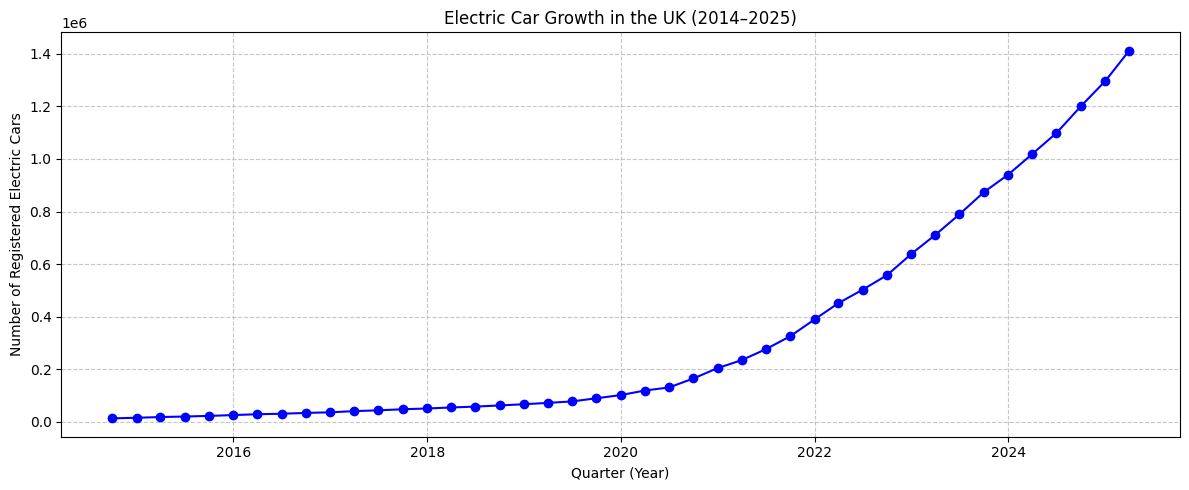

In [58]:
# make a line chart to show how electric cars increased over time
plt.figure(figsize=(12,5))

# plot total registered electric cars per quarter
plt.plot(trend_data.index, trend_data['Registered_Cars'], marker='o', color='blue')

# add title and axis labels
plt.title('Electric Car Growth in the UK (2014–2025)')
plt.xlabel('Quarter (Year)')     # time along the X-axis
plt.ylabel('Number of Registered Electric Cars')   # total EVs along Y-axis

# add light grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# adjust layout
plt.tight_layout()

# display the chart
plt.show()

In [59]:
# calculate quarter-to-quarter percentage growth
trend_data['Growth_Rate'] = trend_data['Registered_Cars'].pct_change() * 100

# calculate year-over-year percentage growth (compare to same quarter last year)
trend_data['YoY_Growth'] = trend_data['Registered_Cars'].pct_change(periods=4) * 100

# check that columns are created correctly
print(trend_data[['Registered_Cars', 'Growth_Rate', 'YoY_Growth']].head(10))

                               Registered_Cars  Growth_Rate  YoY_Growth
Quarter_End                                                            
2014-09-30 23:59:59.999999999            12392          NaN         NaN
2014-12-31 23:59:59.999999999            14571    17.583925         NaN
2015-03-31 23:59:59.999999999            17267    18.502505         NaN
2015-06-30 23:59:59.999999999            19291    11.721781         NaN
2015-09-30 23:59:59.999999999            21683    12.399565   74.975791
2015-12-31 23:59:59.999999999            24818    14.458331   70.324617
2016-03-31 23:59:59.999999999            28029    12.938190   62.326982
2016-06-30 23:59:59.999999999            29891     6.643120   54.947903
2016-09-30 23:59:59.999999999            33054    10.581780   52.442005
2016-12-31 23:59:59.999999999            35349     6.943184   42.432912


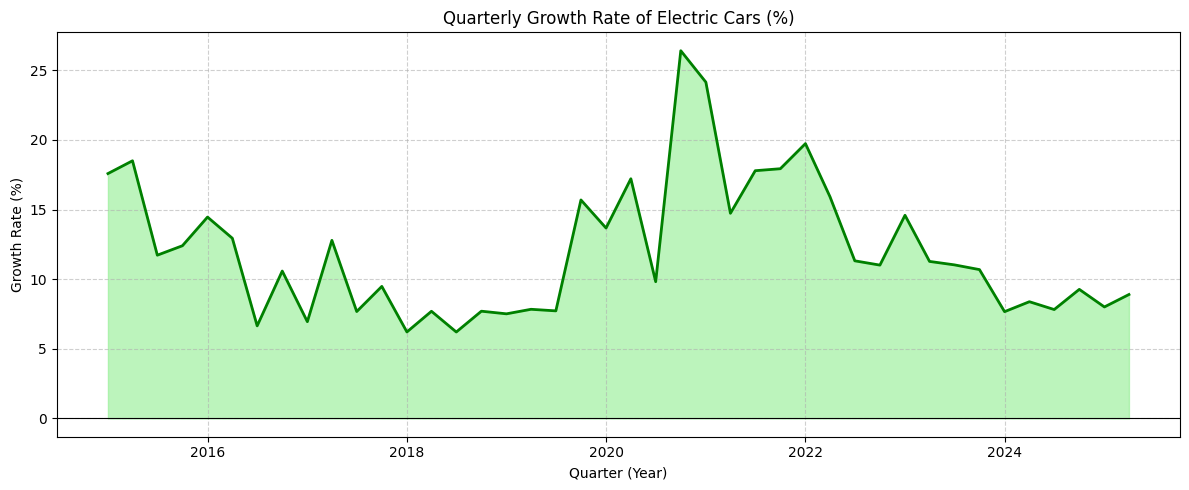

In [60]:
# area chart to show quarterly growth percentage of electric cars
plt.figure(figsize=(12,5))

# fill the area under the growth rate line with light green color
plt.fill_between(trend_data.index, trend_data['Growth_Rate'], color='lightgreen', alpha=0.6)

# draw the growth rate line on top of the area
plt.plot(trend_data.index, trend_data['Growth_Rate'], color='green', linewidth=2)

# add title and axis labels
plt.title('Quarterly Growth Rate of Electric Cars (%)')
plt.xlabel('Quarter (Year)')        # shows time
plt.ylabel('Growth Rate (%)')       # shows how fast EV adoption is growing

# add light grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# add a horizontal line at 0 to separate positive and negative growth
plt.axhline(0, color='black', linewidth=0.8)

# adjust spacing so labels
plt.tight_layout()

# display the final chart
plt.show()

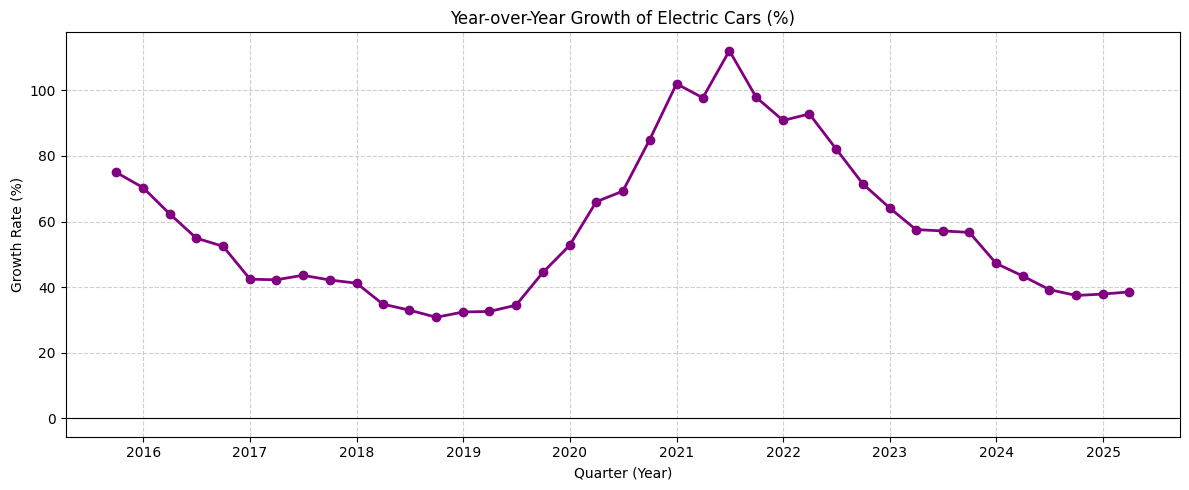

In [61]:
# make a line chart to show the yearly growth rate of electric cars
plt.figure(figsize=(12,5))

# plot the YoY growth line with purple color and dots on each point
plt.plot(trend_data.index, trend_data['YoY_Growth'], color='purple', linewidth=2, marker='o')

# add a clear title and axis labels
plt.title('Year-over-Year Growth of Electric Cars (%)')
plt.xlabel('Quarter (Year)')     # X-axis shows time (quarters)
plt.ylabel('Growth Rate (%)')    # Y-axis shows yearly growth percentage

# add light grid lines to make the chart easier to read
plt.grid(True, linestyle='--', alpha=0.6)

# add a horizontal line at 0% to show the baseline
plt.axhline(0, color='black', linewidth=0.8)

# fix spacing so titles and labels are not cut off
plt.tight_layout()

# show the final chart
plt.show()


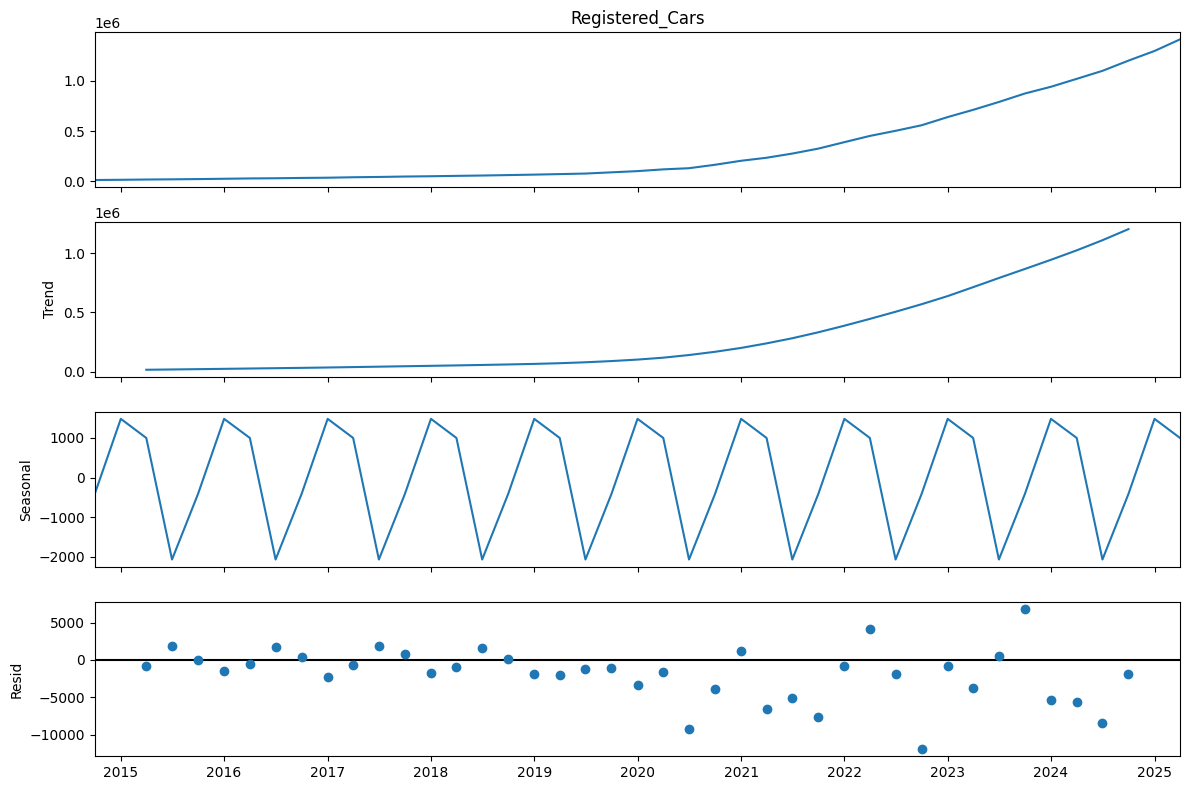

In [62]:
# check if we have enough quarters to see seasonality
if len(trend_data) >= 8:
    # break the data into 3 parts: trend, seasonal pattern, and random noise
    result = seasonal_decompose(trend_data['Registered_Cars'], model='additive', period=4)

    # plot all three parts together
    fig = result.plot()
    fig.set_size_inches(12,8)

    # adjust spacing so nothing is cut off
    plt.tight_layout()

    # show the final chart
    plt.show()
else:
    print("Not enough data points for seasonal analysis.")

#**PreProcessing**

In [63]:
# check if any missing values are present
print("\nMissing values per column:\n", trend_data.isnull().sum())


Missing values per column:
 Quarter            0
Registered_Cars    0
Growth_Rate        1
YoY_Growth         4
dtype: int64


In [64]:
# replace missing growth values with 0
trend_data[['Growth_Rate', 'YoY_Growth']] = trend_data[['Growth_Rate', 'YoY_Growth']].fillna(0)

# check again
print("\nAfter handling missing values:")
print(trend_data.isnull().sum())


After handling missing values:
Quarter            0
Registered_Cars    0
Growth_Rate        0
YoY_Growth         0
dtype: int64


In [65]:
# ensure datetime index
trend_data.index = pd.to_datetime(trend_data.index)

In [66]:
# train/test split (last 8 quarters as test)
n_test = 8
train = trend_data.iloc[:-n_test].copy()
test  = trend_data.iloc[-n_test:].copy()
print("Train shape:", train.shape, "Test shape:", test.shape)

Train shape: (35, 4) Test shape: (8, 4)


# **Model**

In [67]:
# Check if data is stationary

series = train['Registered_Cars'].dropna()

adf_stat, p_value = adfuller(series)[:2]
print(f"ADF Statistic = {adf_stat:.4f} | p-value = {p_value:.4f}")

if p_value < 0.05:
    print("Data is stationary.")
else:
    print(" Data is non-stationary.")

ADF Statistic = 3.3397 | p-value = 1.0000
 Data is non-stationary.


In [68]:
# Fit ARIMA model
order = (1, 1, 1)  # (p, d, q)
print("Training ARIMA model with order:", order)

arima_model = ARIMA(train['Registered_Cars'], order=order).fit()


Training ARIMA model with order: (1, 1, 1)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


RMSE: 54924.42990092977


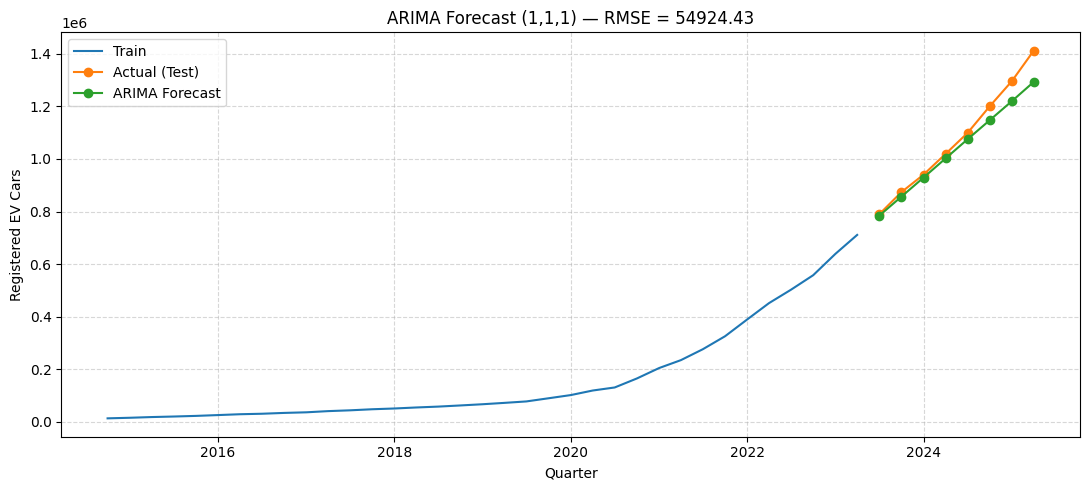

In [69]:
# Forecast next quarters & evaluate
n_steps = len(test)
forecast = arima_model.forecast(steps=n_steps)
forecast = np.asarray(forecast)
forecast_series = pd.Series(forecast, index=test.index)

# calculate RMSE (error)
rmse = np.sqrt(mean_squared_error(test['Registered_Cars'], forecast_series))
print("RMSE:", rmse)

# plot results
plt.figure(figsize=(11,5))
plt.plot(train.index, train['Registered_Cars'], label='Train')
plt.plot(test.index, test['Registered_Cars'], marker='o', label='Actual (Test)')
plt.plot(forecast_series.index, forecast_series, marker='o', label='ARIMA Forecast')
plt.title(f'ARIMA Forecast (1,1,1) — RMSE = {rmse:.2f}')
plt.xlabel('Quarter'); plt.ylabel('Registered EV Cars')
plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout();
plt.show()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


Holt-Winters RMSE: 57,701.98


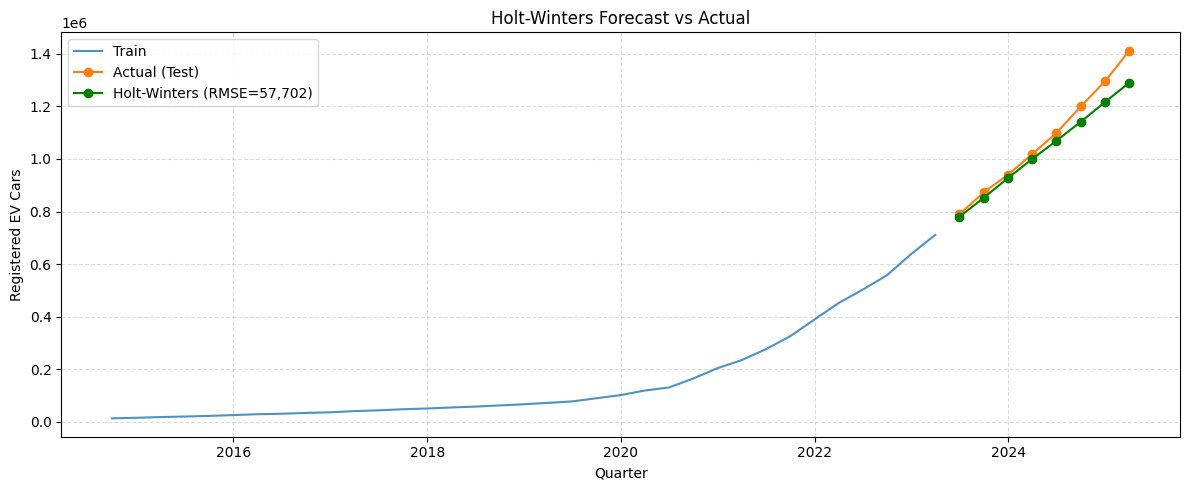

In [70]:
# Holt-Winter forecasting

# Fit Holt-Winters on training data
hw_model = ExponentialSmoothing(
    train['Registered_Cars'],
    trend='add',
    seasonal='add',
    seasonal_periods=4,
    initialization_method='estimated'
).fit(optimized=True)

# Forecast same horizon as test
hw_forecast = hw_model.forecast(steps=len(test))

# Evaluate with RMSE
rmse_hw = np.sqrt(mean_squared_error(test['Registered_Cars'], hw_forecast))
print(f"Holt-Winters RMSE: {rmse_hw:,.2f}")

# Convert forecast to Series for plotting and saving
hw_series = pd.Series(hw_forecast.values, index=test.index, name='HW_Pred')

# Plot train, actual test, and Holt-Winters forecast
plt.figure(figsize=(12,5))
plt.plot(train.index, train['Registered_Cars'], label='Train', alpha=0.8)
plt.plot(test.index, test['Registered_Cars'], 'o-', label='Actual (Test)', color='#ff7f0e')
plt.plot(hw_series.index, hw_series, 'o-', label=f'Holt-Winters (RMSE={rmse_hw:,.0f})', color='green')
plt.title('Holt-Winters Forecast vs Actual')
plt.xlabel('Quarter'); plt.ylabel('Registered EV Cars')
plt.grid(True, linestyle='--', alpha=0.45)
plt.legend(); plt.tight_layout(); plt.show()

# Save predictions
hw_series.to_csv('holt_winters_forecast.csv', header=['HW_Forecast'])


In [72]:
# Settings
LOOK_BACK = 8     # use last 8 quarters to predict next
EPOCHS    = 100
BATCH     = 8

# fit scaler on training values only (avoid leakage)
scaler = MinMaxScaler()
scaler.fit(train['Registered_Cars'].values.reshape(-1,1))

# scale full series for sequence creation
full_scaled = scaler.transform(trend_data['Registered_Cars'].values.reshape(-1,1))


In [73]:
# create supervised sequences
def create_sequences(arr, look_back):
    X, y = [], []
    for i in range(len(arr) - look_back):
        X.append(arr[i:i+look_back, 0])
        y.append(arr[i+look_back, 0])
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(full_scaled, LOOK_BACK)

# use existing test length to split (keeps same test period)
n_test = len(test)
X_train = X_all[:-n_test]
y_train = y_all[:-n_test]
X_test  = X_all[-n_test:]
y_test  = y_all[-n_test:]

# reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], LOOK_BACK, 1))
X_test  = X_test.reshape((X_test.shape[0], LOOK_BACK, 1))

print("Shapes -> X_train:", X_train.shape, "X_test:", X_test.shape)

Shapes -> X_train: (27, 8, 1) X_test: (8, 8, 1)


In [74]:
# simple LSTM model
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(LOOK_BACK,1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [75]:
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_split=0.12,
    callbacks=[es],
    verbose=1
)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - loss: 0.0508 - val_loss: 0.7173
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0613 - val_loss: 0.5677
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0362 - val_loss: 0.4431
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0215 - val_loss: 0.3325
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0150 - val_loss: 0.2384
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0228 - val_loss: 0.1584
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0192 - val_loss: 0.1094
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0170 - val_loss: 0.0900
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0153 - val_loss: 0.0827
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0135 - val_loss: 0.0785
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0094 - val_loss: 0.0716
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0103 - val_l

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
LSTM RMSE: 338,298.06


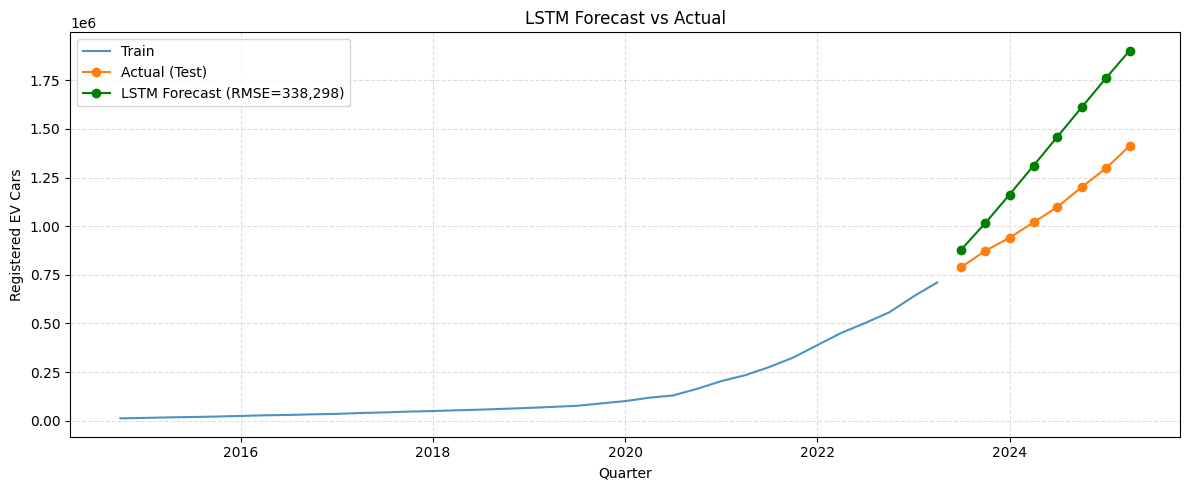

In [76]:
# predict (scaled)
y_pred_scaled = model.predict(X_test)

# inverse scale to original numbers
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_true = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

# create series aligned to test index
lstm_pred_series = pd.Series(y_pred, index=test.index)

# RMSE
rmse_lstm = np.sqrt(mean_squared_error(test['Registered_Cars'], lstm_pred_series))
print(f"LSTM RMSE: {rmse_lstm:,.2f}")

# plot results
plt.figure(figsize=(12,5))
plt.plot(train.index, train['Registered_Cars'], label='Train', alpha=0.8)
plt.plot(test.index, test['Registered_Cars'], 'o-', label='Actual (Test)', color='#ff7f0e')
plt.plot(lstm_pred_series.index, lstm_pred_series, 'o-', label=f'LSTM Forecast (RMSE={rmse_lstm:,.0f})', color='green')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Quarter'); plt.ylabel('Registered EV Cars')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(); plt.tight_layout(); plt.show()

# save predictions
lstm_pred_series.to_csv('lstm_forecast.csv', header=['LSTM_Pred'])
